In [1]:
import networkx as nx
from networkx.algorithms.community import modularity_max as mm
import community
import matplotlib.pyplot as plt
import statistics
import wikipediaapi

Importing graph

In [2]:
path = "/home/ayman/Documents/bpr/data/wikipedia/peaksNew/peaks_graph_20190901_20190915.gexf"
g = nx.read_gexf(path, node_type=None, relabel=True).to_undirected()

Veriying

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


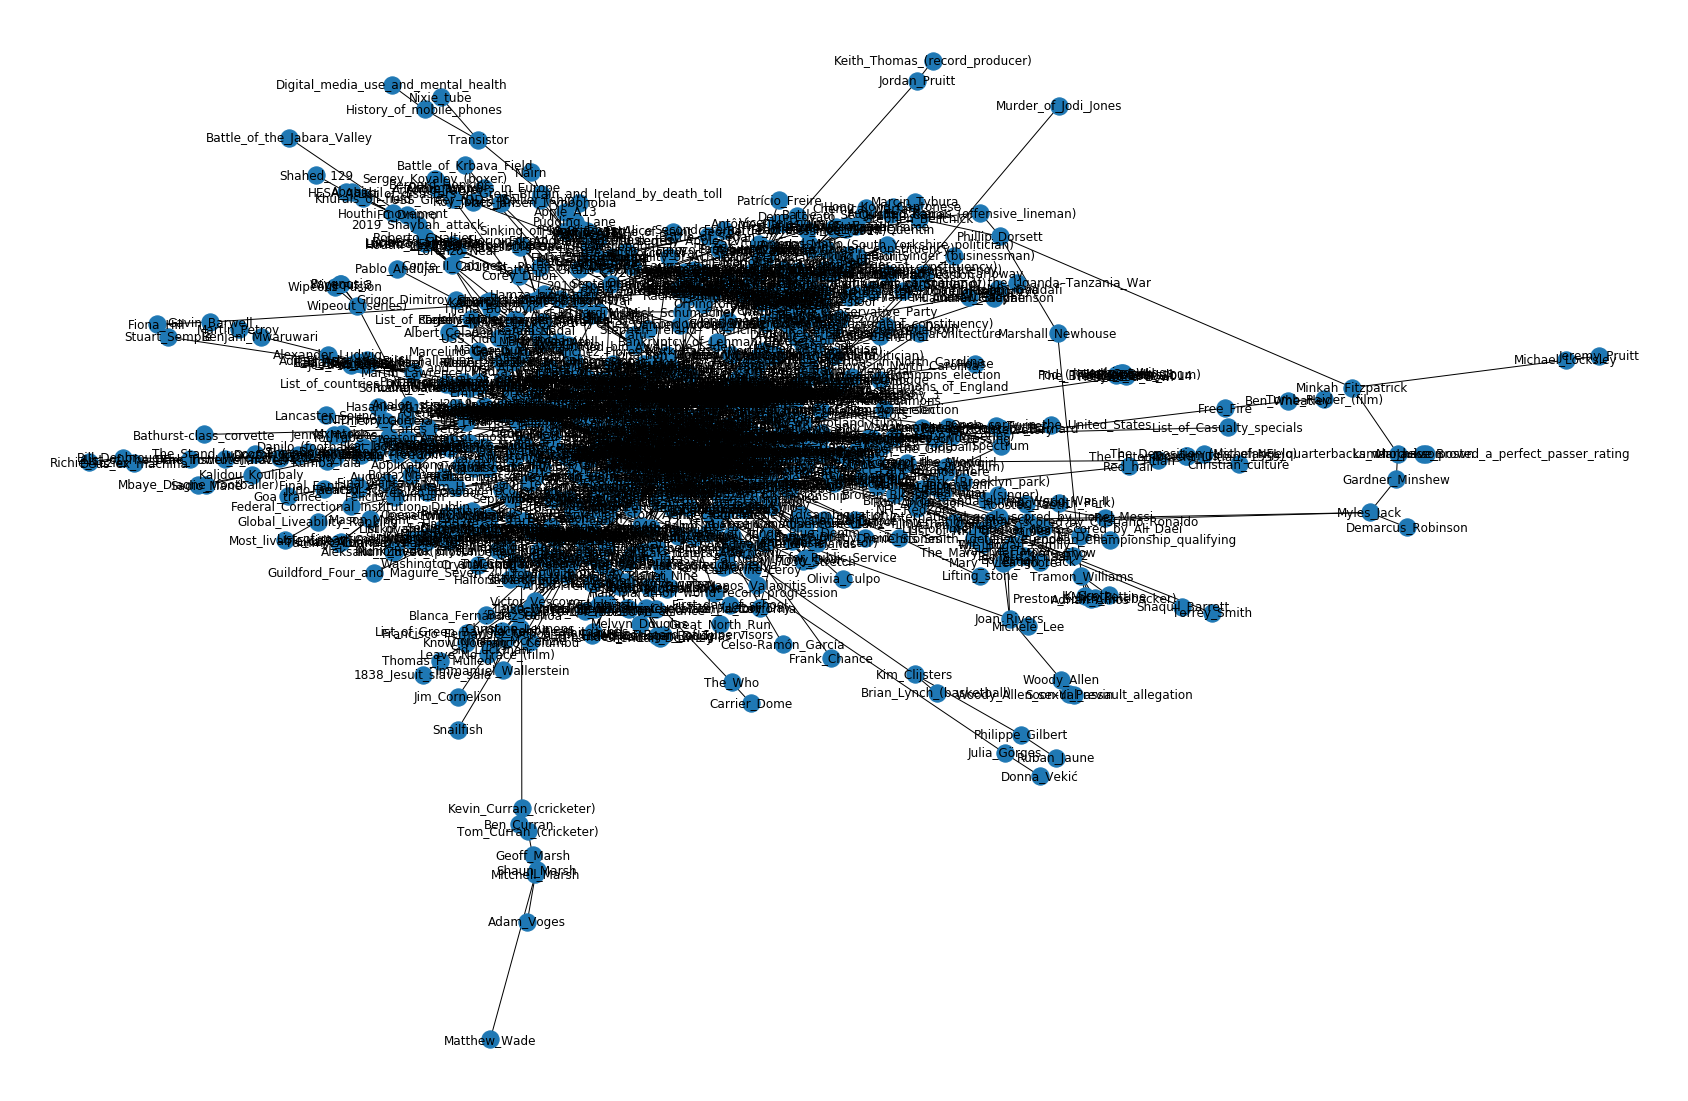

number of nodes : 1105


In [3]:
fig, ax = plt.subplots(figsize=(30, 20)) # set size
nx.draw(g, with_labels=True)
plt.show()
print('number of nodes : ' + str(len(g)))

Degree computation + mean + std + threshold

In [4]:
nodes_with_degrees = g.degree

mean_deg = statistics.mean(l[1] for l in nodes_with_degrees)

std_deg = statistics.stdev(l[1] for l in nodes_with_degrees)

Filtering highly connected nodes

In [5]:
threshold = mean_deg + std_deg*std_deg/2 

nodes_to_remove = list(filter(lambda d : d[1] > threshold, nodes_with_degrees))

n,d = zip(*nodes_to_remove)

g.remove_nodes_from(n)
print('remaining nodes : ' + str(len(g)))

remaining nodes : 1102


Degree of nodes and filtering isolated nodes

In [6]:
nodes_with_degrees = g.degree

nodes_to_remove = list(filter(lambda d : d[1] == 0, nodes_with_degrees))

n,d = zip(*nodes_to_remove)

g.remove_nodes_from(n)

print('remaining nodes : ' + str(len(g)))

remaining nodes : 1009


Keeping only largest connected component

In [7]:
gcc = max(nx.connected_component_subgraphs(g), key=len)

print('remaining nodes : ' + str(len(gcc)))

remaining nodes : 776


plot

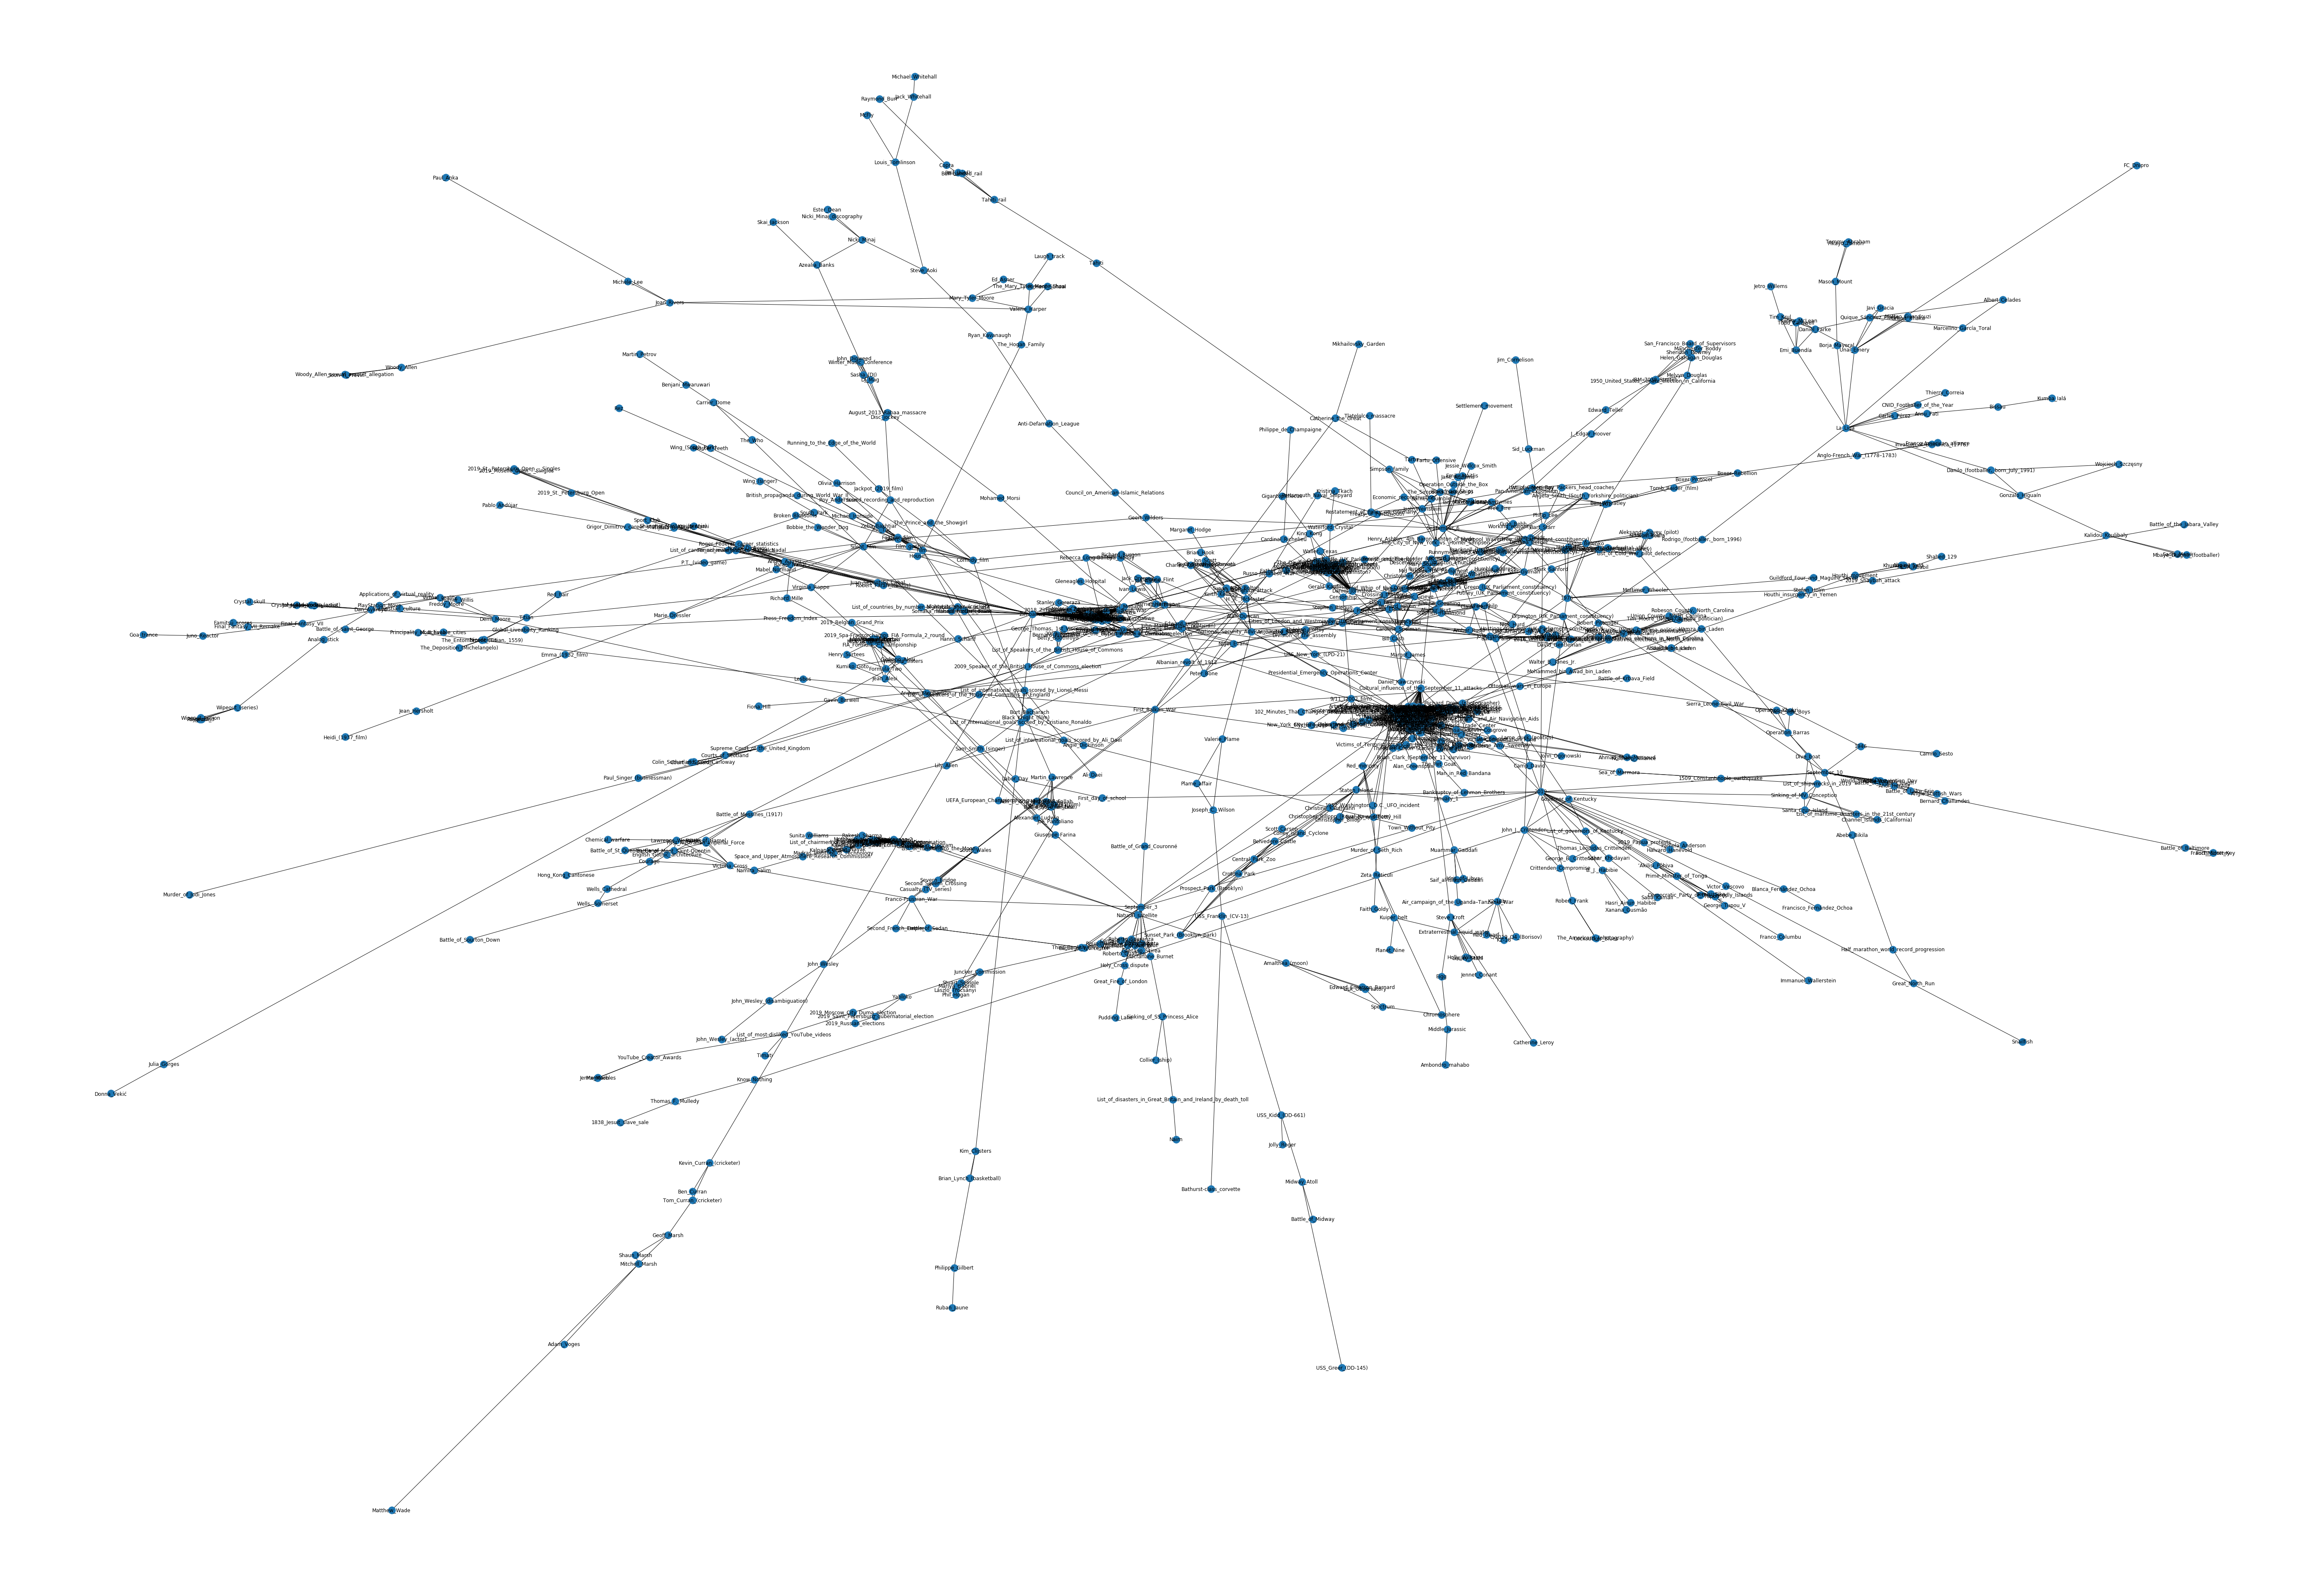

In [8]:
fig, ax = plt.subplots(figsize=(100, 70)) # set size
nx.draw(gcc, with_labels=True)
plt.show()

partitioning

In [9]:
best_partition = community.best_partition(gcc)
print(len(best_partition))

best_partition_dict = {}

for key, value in sorted(best_partition.items()):
    best_partition_dict.setdefault(value, []).append(key)

print(len(best_partition_dict))
print(best_partition_dict[0])
print(sorted(best_partition_dict))

776
38
['1901', '1950_United_States_Senate_election_in_California', '1976', 'Albanian_revolt_of_1912', 'Aleksandr_Zuyev_(pilot)', 'Anglo-French_War_(1778–1783)', 'Battle_of_Krbava_Field', 'Battle_of_Saint_George', 'Blackfriars_Ships', 'Boxer_Protocol', 'Boxer_Rebellion', 'Catherine_the_Great', 'Economic_reconstruction', 'Edward_Teller', 'Emily_Maitlis', 'First_Balkan_War', 'Franco-American_alliance', 'Guildford_Four_and_Maguire_Seven', 'Hakodate', 'Helen_Gahagan_Douglas', 'IBM_7030_Stretch', 'Invasion_of_Dominica_(1778)', 'J._Edgar_Hoover', 'James_F._Byrnes', 'Jane_Addams', 'Jessie_Willcox_Smith', 'Lesbos', 'List_of_Cold_War_pilot_defections', 'Manchester_Boddy', 'Melvyn_Douglas', 'Mikhailovsky_Garden', 'Mikoyan-Gurevich_MiG-25', 'Mortimer_Wheeler', 'Munir_Redfa', 'No_Kum-sok', 'Operation_Outside_the_Box', 'Ottoman_wars_in_Europe', 'Pan-American_Exposition', 'Portsmouth_Naval_Shipyard', 'Principality_of_Achaea', 'Restatement_of_Policy_on_Germany', 'Russo-Japanese_War', 'San_Francisco_B

setup wikipedia-api

In [10]:
wiki_wiki = wikipediaapi.Wikipedia('en')

categoriy of each partition

helpers

In [27]:
#get list of categories of a page
def get_categories(page):
    categories = list(page.categories.keys())
    return categories
    
#filter out hidden categories from a list of categories
def filter_categories_helper(ls):
    res = []
    for category in ls:
        p = wiki_wiki.page(category)
        cs = get_categories(p)
        if not('Category:Hidden categories' in cs):
            res += [category]
    return res

#map each element to frequency in a list    
def count_frequency(my_list): 
      
    # Creating an empty dictionary  
    freq = {} 
    for items in my_list: 
        freq[items] = my_list.count(items)
    return freq

#iterate over pages dict partition
def part_category_fetch(key, dic):
    cat = []
    for title in dic[key]:
#        print('\t' + str(title))
        page = wiki_wiki.page(title)
        cat += get_categories(page)
    print('done fetching')
    return cat

#
def filter_categories(cmf):
    values = list(cmf.values())
    m = statistics.mean(values)
    s = statistics.stdev(values)
    
    cat_map_highfreq = {key:val for key, val in cmf.items() if val >= m}
    
    tmp = cmf
    
    tmp.pop((e for e in cat_map_highfreq.keys()), None)
    
    cat_highfreq_list = list(cat_map_highfreq.keys())   
    filtered_cat = filter_categories_helper(cat_highfreq_list)
    
    tmp = {**tmp, **{k:cat_map_highfreq[k] for k in filtered_cat}}
    
    values = list(tmp.values())
    m = statistics.mean(values)
    s = statistics.stdev(values)
    
    cat_map_highfreq = {key:val for key, val in tmp.items() if val >= m}
    
    cat_highfreq_list = list(cat_map_highfreq.keys())   
    filtered_cat = filter_categories_helper(cat_highfreq_list)
    
    c = {k:cat_map_highfreq[k] for k in filtered_cat}
    
    
    return c


In [28]:
def fetch_categories(bpd):
    part_cat = {}
    
    for part in reversed(sorted(bpd)):
        print(part)
        cat = part_category_fetch(part, bpd)
        cat_map_freq = count_frequency(cat)
        c = filter_categories(cat_map_freq)
        print('**********categories are :')
        for e in c.keys():
            print(str(e) + ' : ' +str(c[e]))
        c2 = {v:k for k,v in c.items()}
        final_cat_freq = max(c2)
        final_cat = c2[final_cat_freq]
        print('**********final category')
        print(str(final_cat)+ ' : '+ str(final_cat_freq))
        part_cat.setdefault(part, []).append(final_cat)

In [30]:
fetch_categories(best_partition_dict)

37
done fetching
**********categories are :
Category:Living people : 2
**********final category
Category:Living people : 2
36
done fetching
**********categories are :
Category:Living people : 3
Category:People from Wall Township, New Jersey : 2
**********final category
Category:Living people : 3
35
done fetching
**********categories are :
Category:Islamic State of Afghanistan : 2
**********final category
Category:Islamic State of Afghanistan : 2
34
done fetching
**********categories are :
Category:Living people : 2
**********final category
Category:Living people : 2
33
done fetching
**********categories are :
Category:Australia One Day International cricketers : 5
Category:Australia Test cricketers : 5
Category:Australia Twenty20 International cricketers : 4
Category:Australian cricket coaches : 2
Category:Australian cricketers : 5
Category:Cricketers who made a century on Test debut : 2
Category:Living people : 7
Category:Melbourne Stars cricketers : 2
Category:Perth Scorchers cricket

ValueError: max() arg is an empty sequence

In [52]:
cat = part_category_fetch(29, best_partition_dict)
cmf = count_frequency(cat)

tmp = cmf

values = list(cmf.values())
m = statistics.mean(values)
s = statistics.stdev(values)
print(m,s)
cat_map_highfreq = {key:val for key, val in cmf.items() if val >= m}
print(len(cat_map_highfreq))
print(len(tmp))
for e in cat_map_highfreq.keys():
    tmp.pop(e, None)
print(len(tmp))
cat_highfreq_list = list(cat_map_highfreq.keys())   
filtered_cat = filter_categories_helper(cat_highfreq_list)
    
tmp.update([(k, cat_map_highfreq[k]) for k in filtered_cat])
    
values = list(tmp.values())
m = statistics.mean(values)
s = statistics.stdev(values)
print(m,s)
cat_map_highfreq = {key:val for key, val in tmp.items() if val >= m}
for k, v in cat_map_highfreq.items():
    print(v,k)
cat_highfreq_list = list(cat_map_highfreq.keys())   
print(len(cat_highfreq_list))
filtered_cat = filter_categories_helper(cat_highfreq_list)
    
c = {k:cat_map_highfreq[k] for k in filtered_cat}
len(c)

done fetching
1.0782608695652174 0.3284152828611681
7
115
108
1 0.0
1 Category:All articles with dead external links
1 Category:Articles incorporating a citation from the 1913 Catholic Encyclopedia with Wikisource reference
1 Category:Articles with dead external links from July 2019
1 Category:Articles with permanently dead external links
1 Category:CS1: Julian–Gregorian uncertainty
1 Category:CS1 French-language sources (fr)
1 Category:CS1 Greek-language sources (el)
1 Category:CS1 errors: markup
1 Category:Christian culture
1 Category:Christianity and society
1 Category:Religious culture
1 Category:Use dmy dates from December 2017
1 Category:Webarchive template wayback links
1 Category:Western culture
1 Category:1st-century Jews
1 Category:All articles needing additional references
1 Category:Articles containing Ancient Greek-language text
1 Category:Articles containing German-language text
1 Category:Articles containing Greek-language text
1 Category:Articles needing additional refe

45